<a href="https://colab.research.google.com/github/gskumlehn/autism-info-llm-comparison/blob/main/network_analysis_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

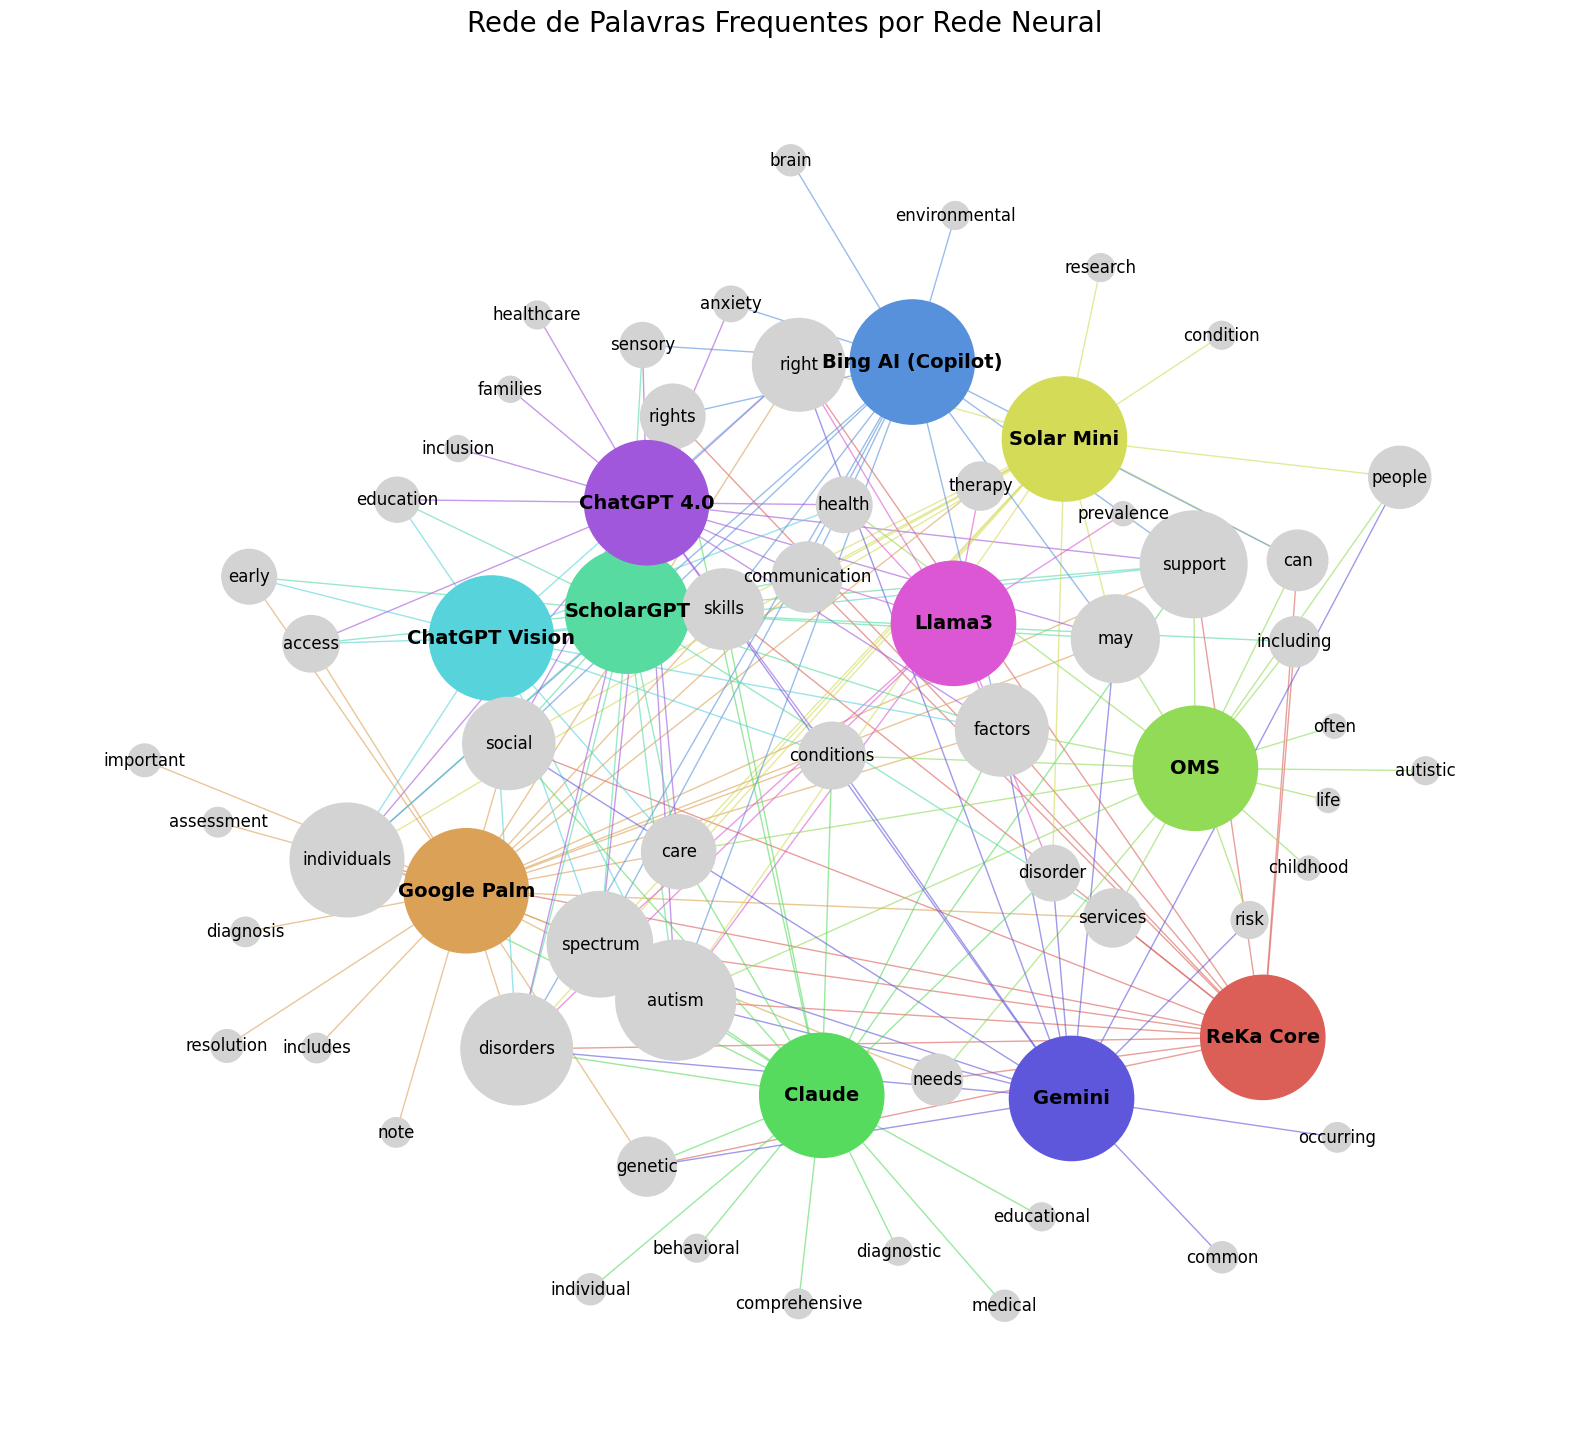

In [52]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from matplotlib.patches import FancyArrowPatch
from matplotlib import colors as mcolors

def draw_curved_edges(G, pos, ax, edge_colors, curvature=0.2, alpha=0.3):
    for i, (u, v) in enumerate(G.edges()):
        if u == v:
            continue  # evita loops

        rad = curvature  # controla a curvatura da linha
        color = edge_colors[i]

        # Pega a posição dos nós
        xy1 = pos[u]
        xy2 = pos[v]

        # Desenha uma curva entre os nós
        arrow = FancyArrowPatch(
            xy1, xy2,
            connectionstyle=f"arc3,rad={rad}",
            arrowstyle='-',
            color=color,
            alpha=alpha,
            linewidth=1.0,
            zorder=0
        )
        ax.add_patch(arrow)


# Carregar CSV
df = pd.read_csv('top_words_per_network (1).csv')

# Filtrar apenas arestas com n > 2
df_filtered = df[df['n'] > 2]

# Criar grafo
G = nx.Graph()
for _, row in df_filtered.iterrows():
    G.add_edge(row['network'], row['word'], weight=row['n'])


networks = df['network'].unique()
word_freq = df_filtered.groupby('word')['n'].sum().to_dict()

# Obter paleta e remover tons de cinza
raw_palette = sns.color_palette("hls", n_colors=12)
palette = [color for color in raw_palette if not all(abs(c - 0.7) < 0.05 for c in color)]  # remove o cinza (~[0.7, 0.7, 0.7])

# Garantir que tenha cores suficientes
if len(palette) < len(networks):
    raise ValueError("Número de redes maior que as cores disponíveis sem o cinza!")

network_color_map = dict(zip(networks, palette))

node_colors = [network_color_map[node] if node in networks else 'lightgray' for node in G.nodes()]
node_sizes = [8000 if node in networks else 100 + word_freq.get(node, 1) * 50 for node in G.nodes()]
# Gerar layout inicial com kamada_kawai_layout
pos = nx.kamada_kawai_layout(G)

# Calcular as distâncias dos nós ao centro
center = np.array([0.0, 0.0])  # Posição central
distances_to_center = {node: np.linalg.norm(np.array([x, y]) - center) for node, (x, y) in pos.items()}

# Ajustar posições para expandir o centro e compactar bordas
scale_factor = 1.5
adjusted_pos = {}
for node, (x, y) in pos.items():
    distance = distances_to_center[node]
    scale = (1 / (distance + 1)) * scale_factor
    adjusted_pos[node] = (x * scale, y * scale)

# Preparar as cores das arestas
edge_colors = []
for u, v in G.edges():
    if u in network_color_map:
        edge_colors.append(network_color_map[u])
    elif v in network_color_map:
        edge_colors.append(network_color_map[v])
    else:
        edge_colors.append("gray")

# Criar a figura principal
fig, ax = plt.subplots(figsize=(20, 18))

# Desenhar os nós
nx.draw_networkx_nodes(G, adjusted_pos, node_color=node_colors, node_size=node_sizes, ax=ax)


# Arestas retas
nx.draw_networkx_edges(G, adjusted_pos, edge_color=edge_colors, alpha=0.6, width=1.0, ax=ax)


# Adicionar os textos
texts = []
for node, (x, y) in adjusted_pos.items():
    fontweight = 'bold' if node in networks else 'normal'
    fontsize = 14 if node in networks else 12
    texts.append(ax.text(x, y, node, fontsize=fontsize, ha='center', va='center', fontweight=fontweight))


ax.set_title("Rede de Palavras Frequentes por Rede Neural", fontsize=20)
ax.axis('off')
plt.show()


In [53]:
# Primeiro, criar um dicionário com as frequências das palavras da OMS
frequencias_oms = df[df['network'] == 'OMS'].set_index('word')['n'].to_dict()

# Função para contar quantas palavras coincidem com a OMS e têm frequência semelhante
def contar_palavras_similares(sub_df, tolerancia=5):
    count = 0
    for _, row in sub_df.iterrows():
        palavra = row['word']
        freq = row['n']
        if palavra in frequencias_oms:
            if abs(freq - frequencias_oms[palavra]) <= tolerancia:
                count += 1
    return count

# Aplicar por rede (excluindo OMS)
redes_df = df[df['network'] != 'OMS']
resultados_similares = redes_df.groupby('network').apply(contar_palavras_similares).reset_index()
resultados_similares.columns = ['network', 'quantidade_palavras_similares']

# Ordenar do maior para o menor
resultados_similares = resultados_similares.sort_values(by='quantidade_palavras_similares', ascending=False)
resultados_similares.head()


<ipython-input-53-86d2a902c9b9>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resultados_similares = redes_df.groupby('network').apply(contar_palavras_similares).reset_index()


,network,quantidade_palavras_similares
1,ChatGPT 4.0,5
8,ScholarGPT,5
5,Google Palm,4
6,Llama3,4
0,Bing AI (Copilot),3
